# Определение стоимости автомобилей

Изучим данные предоставленные сервисом.

## Подготовка данных

### Осмотр данных

In [1]:
# импортируем необходимые библиотеки 
import pandas as pd 
import numpy as np 
from scipy import stats as st 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.3f}'.format) # выводим значения float до 3 знаков после запятой
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [4]:
# сохраним датасет и посмотрим всю информацию о нём 
df = pd.read_csv('/datasets/autos.csv') 
 
def info_df(df):  
    display(df.head()) # первые пять строк 
    display(df.info()) # общую информацию 
    display(df.describe()) # статистическую информацию 
    display(df.isna().sum()) # пропуски 
    display(df.duplicated().sum()) # дубликаты 
                     
display(info_df(df)) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

4

None

<body>
Данные загружены, добавим их описание и изучим.<br/> 

Признаки:<br/> 
DateCrawled — дата скачивания анкеты из базы,<br/> 
VehicleType — тип автомобильного кузова,<br/> 
RegistrationYear — год регистрации автомобиля,<br/> 
Gearbox — тип коробки передач,<br/> 
Power — мощность (л. с.),<br/> 
Model — модель автомобиля,<br/> 
Kilometer — пробег (км),<br/> 
RegistrationMonth — месяц регистрации автомобиля,<br/> 
FuelType — тип топлива,<br/> 
Brand — марка автомобиля,<br/> 
NotRepaired — была машина в ремонте или нет,<br/> 
DateCreated — дата создания анкеты,<br/> 
NumberOfPictures — количество фотографий автомобиля,<br/> 
PostalCode — почтовый индекс владельца анкеты (пользователя),<br/> 
LastSeen — дата последней активности пользователя.<br/> 

Целевой признак:<br/> 
Price — цена (евро).<br/> 

Открылся достаточно большой датасет (16 колонок и очень много строк), сразу видны синтаксические и стилистические нарушения, есть пропуски и дубликаты. Типы данных везде соответствуют. Столбец с почтовыми индексами и количество фотографий автомобиля, а также анкетные данные пользователя для исследования не нужны, поэтому можно удалить их смело. По статистической информации: В столбцах Цена, Мощность обнаружены аномальные значения, а в Месяц регистрации - 0 - это неизвестные значения. В столбце Год регистрации также есть аномальные значения - 1000 и 9999. Точно таким год не может быть. 
    </body>

### Исследовательский анализ данных (EDA)

Посмотрим на распределение количественных значений в датасете.

In [2]:
# Построим графики чтобы посмотреть на распределение
def dist_and_box(df,col):
    global title
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'{title}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'{title}',fontsize=20)

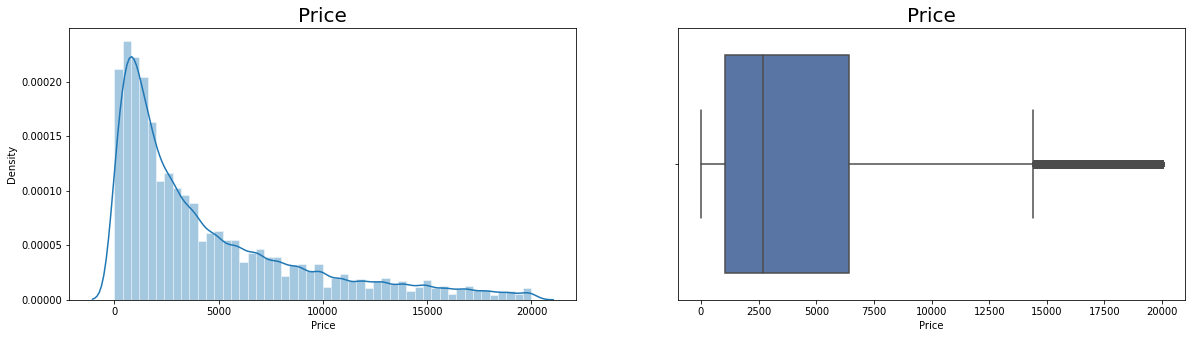

In [5]:
title = 'Price'
dist_and_box(df,'Price')

Значения столбца Цена скошены вправо и видны выбросы после 15000. Возсожно это дорогие авто. За аномальные значения это принимать не стоит. Также видно, что много авто попало в интервал от 0 до 500-1000 приблизительно.

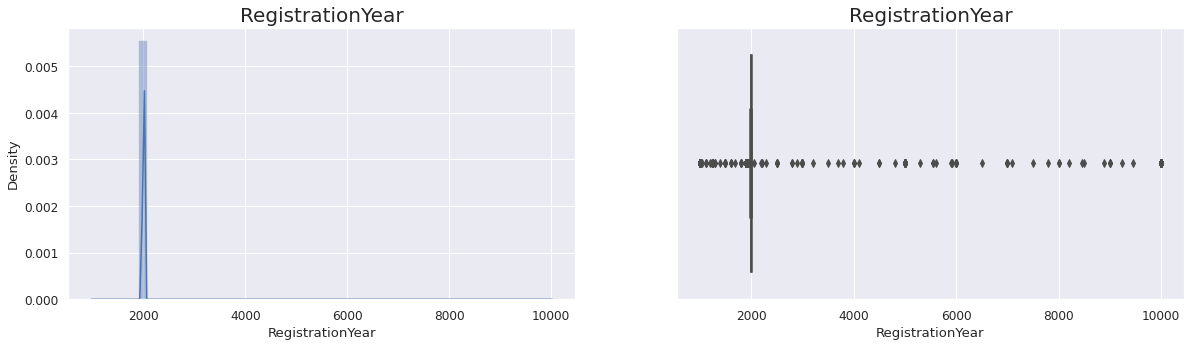

In [6]:
title = 'RegistrationYear'
dist_and_box(df,'RegistrationYear')

Как видим очень много выбросов. Исследуем их подробнее.

In [7]:
df_year = df[(df['RegistrationYear'] < 1999)]

In [8]:
df_year['RegistrationYear'].unique()

array([1993, 1995, 1980, 1998, 1910, 1997, 1990, 1981, 1994, 1991, 1984,
       1992, 1996, 1985, 1989, 1982, 1976, 1983, 1973, 1111, 1969, 1971,
       1987, 1986, 1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978,
       1972, 1968, 1977, 1961, 1960, 1966, 1975, 1963, 1964, 1954, 1958,
       1967, 1959, 1956, 1000, 1941, 1500, 1962, 1929, 1957, 1940, 1949,
       1937, 1951, 1800, 1953, 1234, 1933, 1400, 1950, 1948, 1952, 1200,
       1932, 1255, 1942, 1935, 1936, 1923, 1930, 1001, 1944, 1943, 1934,
       1938, 1688, 1253, 1928, 1919, 1600, 1039, 1300, 1931, 1915, 1920,
       1602, 1947, 1927, 1946])

In [9]:
df_year1 = df[(df['RegistrationYear'] > 2008)]

In [10]:
df_year1['RegistrationYear'].unique()

array([2011, 2014, 2016, 2009, 2018, 2017, 2012, 2010, 2013, 2015, 5000,
       9999, 3200, 8888, 2200, 4100, 3000, 2066, 2019, 8000, 5300, 9000,
       2900, 6000, 5900, 5911, 4000, 8500, 3700, 3800, 4800, 7000, 6500,
       2290, 2500, 9450, 2800, 5555, 5600, 2222, 9996, 8455, 4500, 7800,
       9229, 7100, 8200, 7500, 3500])

Самые адекватные значения это 2019 год и 1960 года, для отсечения выбросов.

In [11]:
df['DateCreated'].unique()

array(['2016-03-24 00:00:00', '2016-03-14 00:00:00',
       '2016-03-17 00:00:00', '2016-03-31 00:00:00',
       '2016-04-04 00:00:00', '2016-04-01 00:00:00',
       '2016-03-21 00:00:00', '2016-03-26 00:00:00',
       '2016-04-07 00:00:00', '2016-03-15 00:00:00',
       '2016-03-11 00:00:00', '2016-03-20 00:00:00',
       '2016-03-23 00:00:00', '2016-03-27 00:00:00',
       '2016-03-12 00:00:00', '2016-03-13 00:00:00',
       '2016-03-18 00:00:00', '2016-03-10 00:00:00',
       '2016-03-07 00:00:00', '2016-03-09 00:00:00',
       '2016-03-08 00:00:00', '2016-04-03 00:00:00',
       '2016-03-29 00:00:00', '2016-03-25 00:00:00',
       '2016-03-28 00:00:00', '2016-03-30 00:00:00',
       '2016-03-22 00:00:00', '2016-02-09 00:00:00',
       '2016-03-05 00:00:00', '2016-04-02 00:00:00',
       '2016-03-16 00:00:00', '2016-03-19 00:00:00',
       '2016-04-05 00:00:00', '2016-03-06 00:00:00',
       '2016-02-12 00:00:00', '2016-03-03 00:00:00',
       '2016-03-01 00:00:00', '2016-03-04 00:0

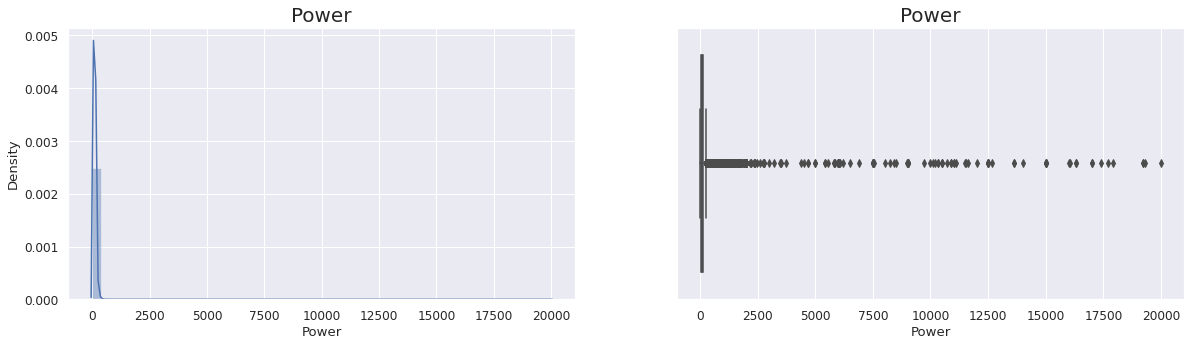

In [12]:
title = 'Power'
dist_and_box(df,'Power')

In [13]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Самая высокая мощность среди авто у Lotus Evija - 2000 л.с. Но в нашем списке такого авто нет, и гнемногие из представленных дотянут и до 1000 лошадок. Поэтому можно смело отсечь данные с мощностью свыше 2000.

In [14]:
df['Power'].value_counts(dropna=False)

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: Power, Length: 712, dtype: int64

Рассмотрим более подробно мощность с нулевым значением - таких значений более 40 тысяч! Помсмотрим какие данные попали в эти значения:

In [15]:
df_p = df[(df['Power'] == 0)]
df_p.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
70,2016-03-08 01:36:42,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,2016-03-08 00:00:00,0,8258,2016-04-05 23:46:00
90,2016-03-23 11:53:21,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN,2016-03-23 00:00:00,0,40210,2016-03-23 11:53:21


Как видим с нулево мощностью совершенно нормальные авто, и с адекватным пробегом и по году. Значит эти значения надо заменить.

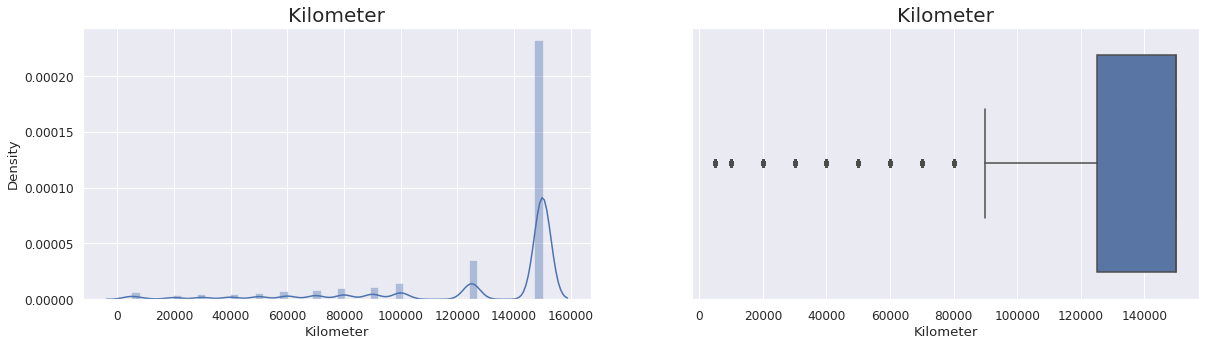

In [16]:
title = 'Kilometer'
dist_and_box(df,'Kilometer')

Значения столбца Пробег скошены влево. Маленькие значения попали в выброс.

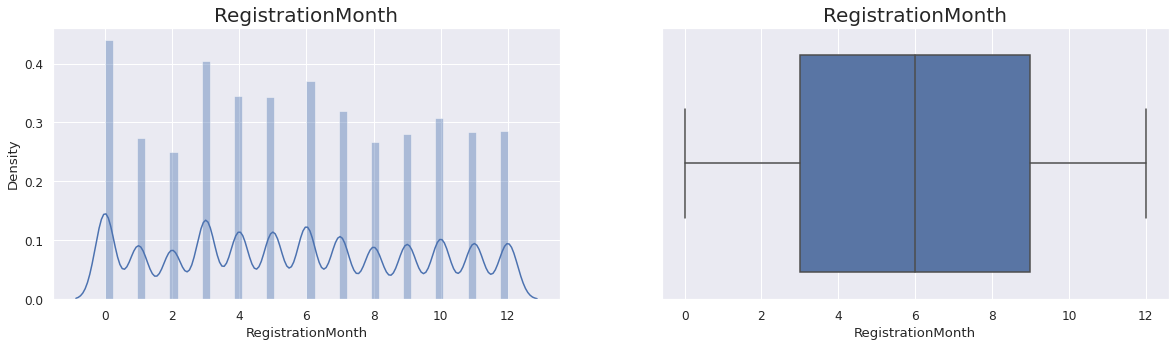

In [17]:
title = 'RegistrationMonth'
dist_and_box(df,'RegistrationMonth')

Здесь достаточно нормально распределение у каждого месяца, соответствующие пики. Но мы видим 13 месяц - нулевой! Соответственно его также надо заменить. Поскольку нулевые значения - это просто неихвестные, но в модель передавать такие данные не стоит.

Посмотрим на корреляцию.

Величина и сила коэффициента корреляции. Величина коэффициента корреляции отражает силы связи. При оценке силы связи коэффициентов корреляции используется шкала Чеддока (https://statpsy.ru/correlation/velicina/):

|Значение      |Интерпретация|
|:-------------|:------------|
|от 0 до 0,3   |очень слабая |
|от 0,3 до 0,5 |слабая       |
|от 0, 5 до 0,7|средняя      |
|от 0,7 до 0, 9|высокая      |
|от 0,9 до 1   |очень высокая|

<AxesSubplot:>

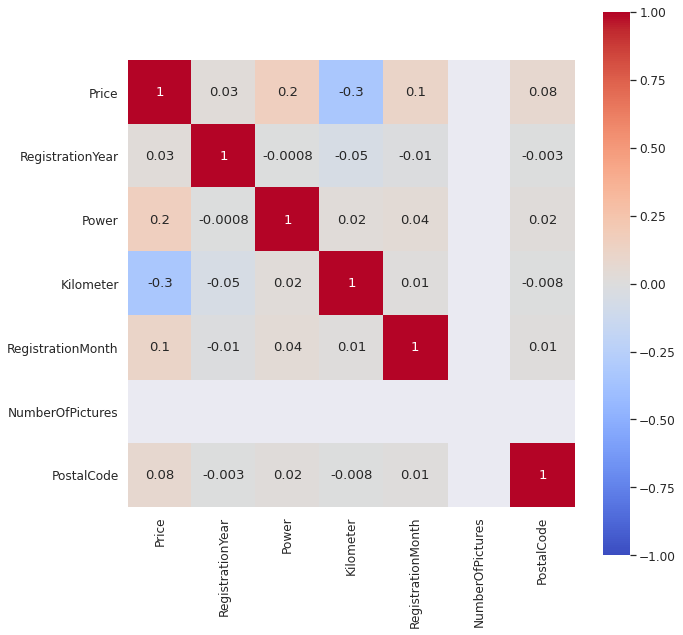

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True, ax = ax)

Корреляция очень слабая.

Посмотрим мультиколлинераность: проверим корреляцию признаков между собой.

<AxesSubplot:>

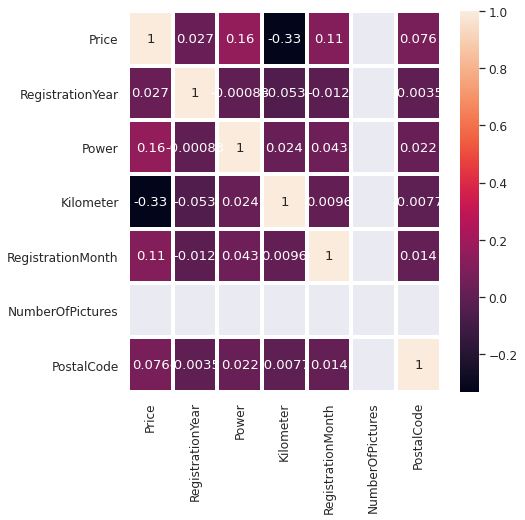

In [19]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

Также, как и количественные признаки категориальные не коррелируют между собой.

У нас есть прпоуски в категориальных значениях: тип кузова, коробка передач, модель, тип топлива, был ли в ремонте - стоит подумать над их заменой. Нули и аномальные значения. Дальше пошагово произведём предобработку данных.

### Предобработка данных

Далее проведём предобработку данных: 
* удалим лишние столбцы, 
* устраним синтаксические и стилистические нарушения, 
* удалим дубликаты,
* отсечём аномальные значения,
* заменим категориальные пропуски,
* обработаем нули.

#### Удалим лишние столбцы

In [20]:
# удаление лишних столбцов 
df = df.drop(columns = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis = 1)  
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


#### Устраним синтаксические и стилистические нарушения

In [21]:
# переименуем столбцы и приведём к нижнему регистру 
df = df.rename(columns={ 
                  "VehicleType": "vehicle_type", 
                  "RegistrationYear": "registration_year", 
                  "RegistrationMonth": "registration_month",
                  "FuelType": "fuel_type",
                  "NotRepaired": "not_repaired",
                  "NumberOfPictures": "number_of_pictures"   
}) 
 
df.columns = [x.lower() for x in df.columns] 

df.head() 

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


#### Удалим дубликаты

In [22]:
df = df.drop_duplicates()
df.duplicated().sum()

0

#### Отсечём аномальные значения

In [27]:
df = df[(df['registration_year'] < 2019)&(df['registration_year'] > 1960)&(df['power'] < 2000)]
df.describe()

,price,registration_year,power,kilometer,registration_month
count,326006.000,326006.000,326006.000,326006.000,326006.000
mean,4403.550,2003.148,107.382,128300.461,5.703
std,4515.196,7.230,71.397,37742.142,3.722
min,0.000,1961.000,0.000,5000.000,0.000
25%,1000.000,1999.000,69.000,125000.000,3.000
50%,2700.000,2003.000,105.000,150000.000,6.000
75%,6350.000,2008.000,141.000,150000.000,9.000
max,20000.000,2018.000,1999.000,150000.000,12.000


#### Заменим категориальные пропуски.

In [28]:
# ещё раз проверяем, что в новом датасете есть пропуски
df.isna().sum()

price                     0
vehicle_type              0
registration_year         0
gearbox               17219
power                     0
model                 18219
kilometer                 0
registration_month        0
fuel_type             30771
brand                     0
not_repaired          65953
dtype: int64

##### Пропуски в типе кузова

In [29]:
df['vehicle_type'].value_counts(dropna=False)

sedan          83436
small          73426
wagon          59628
other          38000
bus            26776
convertible    18714
coupe          15092
suv            10934
Name: vehicle_type, dtype: int64

Среди разных типов кузова есть также и значение other. Заменим пропуски на значение-заглушку other.

In [30]:
df['vehicle_type'] = df['vehicle_type'].fillna('other')

df['vehicle_type'].value_counts(dropna=False)

sedan          83436
small          73426
wagon          59628
other          38000
bus            26776
convertible    18714
coupe          15092
suv            10934
Name: vehicle_type, dtype: int64

##### Пропуски в коробке передач

In [31]:
df['gearbox'].value_counts(dropna=False)

manual    247747
auto       61040
NaN        17219
Name: gearbox, dtype: int64

Представлено двумя типами передач. Но удобнее всего также заполнить пропуски на значение-заглушку other.

In [32]:
df['gearbox'] = df['gearbox'].fillna('other')

df['gearbox'].value_counts(dropna=False)

manual    247747
auto       61040
other      17219
Name: gearbox, dtype: int64

##### Пропуски в модели

In [33]:
df['model'].value_counts(dropna=False)

golf                  26419
other                 23005
NaN                   18219
3er                   18026
polo                  11918
                      ...  
serie_2                   7
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 251, dtype: int64

Среди различных моделей, есть и значение другое! Логично будет пропуски заменить на это значение-заглушку.

In [34]:
df['model'] = df['model'].fillna('other')

df['model'].value_counts(dropna=False)

other                 41224
golf                  26419
3er                   18026
polo                  11918
corsa                 11365
                      ...  
serie_2                   7
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

##### Пропуски в типе топлива

In [35]:
df['fuel_type'].value_counts(dropna=False)

petrol      199860
gasoline     89409
NaN          30771
lpg           4932
cng            526
hybrid         227
other          192
electric        89
Name: fuel_type, dtype: int64

Опять появилось значение другое! Значит и его мы можем использовать при замене, как значение-заглушку.

In [36]:
df['fuel_type'] = df['fuel_type'].fillna('other')

df['fuel_type'].value_counts(dropna=False)

petrol      199860
gasoline     89409
other        30963
lpg           4932
cng            526
hybrid         227
electric        89
Name: fuel_type, dtype: int64

##### Пропуски в столбце ремонт

In [37]:
df['not_repaired'].value_counts(dropna=False)

no     225706
NaN     65953
yes     34347
Name: not_repaired, dtype: int64

Есть два значения, был и не был ремонт. Но, относить пропуски к какому-либо - не праавильно, мы не можем это правильно предположить. Поэтому также меняем на значение-заглушку.

In [38]:
df['not_repaired'] = df['not_repaired'].fillna('other')

df['not_repaired'].value_counts(dropna=False)

no       225706
other     65953
yes       34347
Name: not_repaired, dtype: int64

#### Обработаем нули.

##### Нули в Цене

У цены был выброс более 15000 и также видны нулевые значения. Посмотрим более детально на них.

In [39]:
df[df['price'] > 15000].head(30)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
14,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no
33,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no
172,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no
179,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no
204,18400,wagon,2011,auto,313,5er,150000,11,gasoline,bmw,no
236,15700,sedan,2011,manual,170,golf,90000,3,gasoline,volkswagen,no
282,18700,coupe,2009,auto,213,mustang,80000,8,petrol,ford,no
287,16150,suv,2011,manual,150,tiguan,30000,4,petrol,volkswagen,no
313,16500,coupe,2007,manual,265,z_reihe,150000,3,petrol,bmw,no


Здесь действительно видно, что дорогие машины, поэтому эти значения не будем трогать.

In [40]:
df[df['price'] < 500].head(30)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
16,300,other,2016,other,60,polo,150000,0,petrol,volkswagen,other
23,450,small,1997,manual,50,arosa,150000,5,petrol,seat,no
32,245,sedan,1994,other,0,golf,150000,2,petrol,volkswagen,no
35,350,other,2016,manual,75,golf,150000,4,petrol,volkswagen,no
40,0,other,1990,other,0,corsa,150000,1,petrol,opel,other
59,1,suv,1994,manual,286,other,150000,11,other,sonstige_autos,other
60,200,coupe,1995,manual,102,3er,150000,4,petrol,bmw,other
79,150,other,2016,manual,75,astra,150000,3,petrol,opel,yes


Даже на предварительном просмотре, видно нулевую стоимость. В жизни, стоимость авто меньше 100 евро - это уже на разбор. Явно  не ходовая машина. Данные с нулевыми значениями - это либо самые разбитые машины, либо ошибка в заполнении данных. Но достоверно узнать это невозможно, поэтому лучше исключить нули из датасета.

In [41]:
df = df[df['price'] != 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316759 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               316759 non-null  int64 
 1   vehicle_type        316759 non-null  object
 2   registration_year   316759 non-null  int64 
 3   gearbox             316759 non-null  object
 4   power               316759 non-null  int64 
 5   model               316759 non-null  object
 6   kilometer           316759 non-null  int64 
 7   registration_month  316759 non-null  int64 
 8   fuel_type           316759 non-null  object
 9   brand               316759 non-null  object
 10  not_repaired        316759 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.0+ MB


##### Нули в мощности

Посмотрим какие бренды вошли в датасет, отсортированный с нулевыми значениями по мощности.

In [42]:
df_po = df[(df['power'] == 0)]
df_po['brand'].unique()

array(['volkswagen', 'renault', 'opel', 'audi', 'bmw', 'fiat',
       'mitsubishi', 'volvo', 'mercedes_benz', 'nissan', 'sonstige_autos',
       'chevrolet', 'peugeot', 'citroen', 'mazda', 'ford', 'trabant',
       'mini', 'smart', 'skoda', 'seat', 'porsche', 'honda', 'suzuki',
       'daewoo', 'toyota', 'hyundai', 'lancia', 'jaguar', 'kia',
       'chrysler', 'rover', 'lada', 'alfa_romeo', 'dacia', 'daihatsu',
       'saab', 'subaru', 'jeep', 'land_rover'], dtype=object)

Как видим здесь совершенно разные марки авто, и дешёвые и дорогие. Поэтому смело можно сделать медианное значение по мощности и заменить им нули.

In [43]:
new_value = df['power'].median()
new_value

105.0

Получилось средняя мощность. 105 лошадок действительно может быть у разных моделей по цене.

In [44]:
df['power'].where(~(df.power == 0), other=new_value, inplace=True)
df['power'].value_counts(dropna=False)

105     42959
75      21417
60      14098
150     12911
101     11953
        ...  
1223        1
519         1
1992        1
525         1
1151        1
Name: power, Length: 599, dtype: int64

##### Нули в месяце

Нули в месяце заменим значением 12. Поскольку достоверно невозможно определить взимосвязь.

In [45]:
df.loc[(df.registration_month == 0), 'registration_month'] = 12
df['registration_month'].value_counts(dropna=False)

12    52641
3     31120
6     28407
4     26684
5     26300
7     24677
10    23434
11    21591
9     21458
1     20909
8     20329
2     19209
Name: registration_month, dtype: int64

**Вывод**

По первому разделу было проведен исслеодвательский анализ и предобработка данных. Расммотрены аномалии и выбросы в столбцах. устранены синтаксические и стилистические нарушения, удалены дубликаты, заменены пропуски в категориальных данных, отсечены аномалии и нулевые значения в целевом признаке. Заменены нулевые значения в мощности и месяце регистрации.

## Обучение моделей

Перед обучением моделей необходимо произвести кодирование и масштабирование. Поскольку в датасете есть категориальные признаки, необходимо их преобразовать. Сделаем две техники кодирования: сначала One-Hot Encoding без столбцов модель и бренд, а потом LabelEncoding именно для столбцов модель и бренд! Именно так нужно, потому, что если кодировать и эти столбцы техникой OHE то это приведёт к разрастанию данных и преджсказание модели будет неточным. У этих столбцов очень много знчений. Для бустинговой модели не нужно применять кодирование, только масштабирование признаков.

### Подготовка к обучению

#### Кодирование техникой OHE и LabelEncoding

Сначала кодируем техникой OHE без столбцов модель и бренд

In [46]:
df_ohe = pd.get_dummies(df.drop(columns = ['model', 'brand'], axis = 1), drop_first=True) 
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316759 entries, 0 to 354368
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   price                     316759 non-null  int64
 1   registration_year         316759 non-null  int64
 2   power                     316759 non-null  int64
 3   kilometer                 316759 non-null  int64
 4   registration_month        316759 non-null  int64
 5   vehicle_type_convertible  316759 non-null  uint8
 6   vehicle_type_coupe        316759 non-null  uint8
 7   vehicle_type_other        316759 non-null  uint8
 8   vehicle_type_sedan        316759 non-null  uint8
 9   vehicle_type_small        316759 non-null  uint8
 10  vehicle_type_suv          316759 non-null  uint8
 11  vehicle_type_wagon        316759 non-null  uint8
 12  gearbox_manual            316759 non-null  uint8
 13  gearbox_other             316759 non-null  uint8
 14  fuel_type_electric  

Добавляем к датасету столбцы модель и бренд.

In [47]:
df_ohe['model'] = df['model']
df_ohe['brand'] = df['brand']
df_ohe.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316759 entries, 0 to 354368
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   price                     316759 non-null  int64 
 1   registration_year         316759 non-null  int64 
 2   power                     316759 non-null  int64 
 3   kilometer                 316759 non-null  int64 
 4   registration_month        316759 non-null  int64 
 5   vehicle_type_convertible  316759 non-null  uint8 
 6   vehicle_type_coupe        316759 non-null  uint8 
 7   vehicle_type_other        316759 non-null  uint8 
 8   vehicle_type_sedan        316759 non-null  uint8 
 9   vehicle_type_small        316759 non-null  uint8 
 10  vehicle_type_suv          316759 non-null  uint8 
 11  vehicle_type_wagon        316759 non-null  uint8 
 12  gearbox_manual            316759 non-null  uint8 
 13  gearbox_other             316759 non-null  uint8 
 14  fuel

Кодируем нужные столбцы другой техникой.

In [48]:
df_ohe['model'] = labelencoder.fit_transform(df_ohe['model'])
df_ohe['brand'] = labelencoder.fit_transform(df_ohe['brand'])
df_ohe.head()

,price,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,not_repaired_other,not_repaired_yes,model,brand
0,480,1993,105,150000,12,0,0,1,0,0,...,0,0,0,0,0,1,1,0,116,38
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,1,0,0,0,0,0,1,166,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,1,0,0,0,0,1,0,117,14
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,1,0,0,116,38
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,1,0,0,0,0,0,0,101,31


Итого получилось 23 столбца! Приемлимо. Можно продолжать работу и поделить выборки. 

#### Деление выборок

In [49]:
# выборки для техники OHE
# признаки и цели для исходного датасета
target_ohe = df_ohe['price'] 
features_ohe = df_ohe.drop('price', axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
                                                                                   features_ohe,
                                                                                   target_ohe,
                                                                                   test_size=0.3,
                                                                                   random_state=0)

# посмотрим на размер новых даатасетов, на вход функция принимает все датасеты сразу
def info_df(features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe): 
    df_all = [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]
    for i in df_all:
        print(i.shape)
                    
display(info_df(features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe))

(221731, 23)
(95028, 23)
(221731,)
(95028,)


None

In [50]:
# выборки без кодировки
# признаки и цели для исходного датасета
target = df['price'] 
features = df.drop('price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features,target,
                                                                                     test_size=0.3,
                                                                                     random_state=0)

# посмотрим на размер новых даатасетов, на вход функция принимает все датасеты сразу
def info_df(features_train, features_test, target_train, target_test): 
    df_all = [features_train, features_test, target_train, target_test]
    for i in df_all:
        print(i.shape)
                    
display(info_df(features_train, features_test, target_train, target_test))

(221731, 10)
(95028, 10)
(221731,)
(95028,)


None

#### Масштабирование признаков во всех выборках

In [51]:
# получим признаки для масштабирования 
numeric_features = features.select_dtypes([np.number]).columns
numeric_features

Index(['registration_year', 'power', 'kilometer', 'registration_month'], dtype='object')

In [52]:
# функция для масштабирования
def scal_func (features_train, features_test):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric_features])
    
    features_train[numeric_features] = scaler.transform(features_train[numeric_features])
    features_test[numeric_features] = scaler.transform(features_test[numeric_features])
    
    return features_train, features_test

In [53]:
# масштабирование данных с кодировкой ohe
features_train_ohe, features_test_ohe = scal_func(features_train_ohe, features_test_ohe)

# проверяем результат масштабирования
display(features_train_ohe.describe())
display(features_test_ohe.describe())

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,not_repaired_other,not_repaired_yes,model,brand
count,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,...,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000,221731.000
mean,-0.000,-0.000,0.000,0.000,0.058,0.046,0.110,0.258,0.227,0.034,...,0.000,0.278,0.001,0.015,0.089,0.616,0.195,0.102,112.070,20.832
std,1.000,1.000,1.000,1.000,0.234,0.210,0.313,0.438,0.419,0.181,...,0.017,0.448,0.026,0.123,0.285,0.486,0.396,0.303,69.864,13.257
min,-5.890,-1.978,-3.299,-1.648,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.586,-0.605,-0.092,-0.812,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,42.000,9.000
50%,-0.028,-0.237,0.576,0.023,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,116.000,24.000
75%,0.670,0.382,0.576,0.858,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,166.000,33.000
max,2.066,31.467,0.576,1.415,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,249.000,39.000


,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,not_repaired_other,not_repaired_yes,model,brand
count,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,...,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000,95028.000
mean,0.007,0.009,-0.006,0.006,0.058,0.046,0.110,0.257,0.225,0.034,...,0.000,0.278,0.001,0.015,0.090,0.614,0.194,0.103,112.192,20.874
std,0.998,1.036,1.003,0.998,0.234,0.210,0.313,0.437,0.418,0.181,...,0.015,0.448,0.028,0.121,0.286,0.487,0.396,0.304,69.857,13.239
min,-5.890,-1.978,-3.299,-1.648,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.586,-0.588,-0.092,-0.812,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,42.000,10.000
50%,-0.028,-0.237,0.576,0.023,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,116.000,24.000
75%,0.670,0.399,0.576,0.858,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,166.000,33.000
max,2.066,31.450,0.576,1.415,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,249.000,39.000


In [54]:
# масштабирование данных без кодировки
features_train, features_test = scal_func(features_train, features_test)

# проверяем результат масштабирования
display(features_train.describe())
display(features_test.describe())

,registration_year,power,kilometer,registration_month
count,221731.000,221731.000,221731.000,221731.000
mean,-0.000,-0.000,0.000,0.000
std,1.000,1.000,1.000,1.000
min,-5.890,-1.978,-3.299,-1.648
25%,-0.586,-0.605,-0.092,-0.812
50%,-0.028,-0.237,0.576,0.023
75%,0.670,0.382,0.576,0.858
max,2.066,31.467,0.576,1.415


,registration_year,power,kilometer,registration_month
count,95028.000,95028.000,95028.000,95028.000
mean,0.007,0.009,-0.006,0.006
std,0.998,1.036,1.003,0.998
min,-5.890,-1.978,-3.299,-1.648
25%,-0.586,-0.588,-0.092,-0.812
50%,-0.028,-0.237,0.576,0.023
75%,0.670,0.399,0.576,0.858
max,2.066,31.450,0.576,1.415


In [55]:
display(features_train.info())
display(features_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221731 entries, 66033 to 341192
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vehicle_type        221731 non-null  object 
 1   registration_year   221731 non-null  float64
 2   gearbox             221731 non-null  object 
 3   power               221731 non-null  float64
 4   model               221731 non-null  object 
 5   kilometer           221731 non-null  float64
 6   registration_month  221731 non-null  float64
 7   fuel_type           221731 non-null  object 
 8   brand               221731 non-null  object 
 9   not_repaired        221731 non-null  object 
dtypes: float64(4), object(6)
memory usage: 18.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95028 entries, 222323 to 23950
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vehicle_type        95028 non-null  object 
 1   registration_year   95028 non-null  float64
 2   gearbox             95028 non-null  object 
 3   power               95028 non-null  float64
 4   model               95028 non-null  object 
 5   kilometer           95028 non-null  float64
 6   registration_month  95028 non-null  float64
 7   fuel_type           95028 non-null  object 
 8   brand               95028 non-null  object 
 9   not_repaired        95028 non-null  object 
dtypes: float64(4), object(6)
memory usage: 8.0+ MB


None

### Обучение

#### Линейная регрессия

Выберем для обучения такие модели: линейная регрессия, случайный лес, решающее дерево, CatBoost, LightGBM.

neg_mean_squared_error - rmse - отрицательное значение для "mean_squared_error". Чем ближе значение к нулю, тум лучше.

In [56]:
lr = LinearRegression() # объявляем модель

lr_params = {'fit_intercept':[True,False], 'normalize':[True,False]} # объявляем параметры
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='neg_mean_squared_error') # объявляем подбор гиперпараметров + скоринг
lr_grid.fit(features_train_ohe, target_train_ohe) # учим модель

display("RMSE составляет", lr_grid.best_score_)
display('Наилучшие подобранные параметры', lr_grid.best_params_)

'RMSE составляет'

-9258240.15094552

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': True}

#### Случайный лес

In [57]:
forest = RandomForestRegressor(random_state=12345) # объявляем модель

forest_params = {'n_estimators': range(1, 10), 'max_depth': range(1,5)} # объявляем параметры
forest_grid = GridSearchCV(forest, forest_params, cv=5, scoring='neg_mean_squared_error') # объявляем подбор гиперпараметров
forest_grid.fit(features_train_ohe, target_train_ohe) # учим модель

display("RMSE составляет", forest_grid.best_score_)
display('Наилучшие подобранные параметры', forest_grid.best_params_)

'RMSE составляет'

-7086216.230717411

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 9}

#### Дерево решений

In [58]:
dtr = DecisionTreeRegressor(random_state=12345) # объявляем модель

dtr_params = {'max_depth': range(1,15), 'min_samples_split': range(2,7)} 
# объявляем параметры
# max_depth — максимальная глубина деревьев
# min_samples_split — минимальное число объектов, 
#необходимое для того, чтобы узел дерева мог бы расщепиться

dtr_grid = GridSearchCV(dtr, dtr_params, cv=5, scoring='neg_mean_squared_error') # объявляем подбор гиперпараметров
dtr_grid.fit(features_train_ohe, target_train_ohe) # учим модель

display("RMSE составляет", dtr_grid.best_score_)
display('Наилучшие подобранные параметры', dtr_grid.best_params_)

'RMSE составляет'

-3939315.7000434785

'Наилучшие подобранные параметры'

{'max_depth': 13, 'min_samples_split': 6}

#### CatBoost

In [59]:
# подготовка для бустинга категориальных признаков
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

cbr = CatBoostRegressor(cat_features = cat_columns)

cbr_params = {'depth': [1, 3]} #'learning_rate': [0.03, 0.04] ОЧЕНЬ ДОЛГО УЧИТСЯ!
# learning_rate или eta – скорость обучения 
# depth = глубина дерева 

cbr_grid = GridSearchCV(cbr, cbr_params, cv=5, scoring='neg_mean_squared_error') # объявляем подбор гиперпараметров
cbr_grid.fit(features_train, target_train) # учим модель

display("RMSE составляет", cbr_grid.best_score_)
display('Наилучшие подобранные параметры', cbr_grid.best_params_)

Learning rate set to 0.092791
0:	learn: 4394.1835809	total: 90.7ms	remaining: 1m 30s
1:	learn: 4290.7646980	total: 116ms	remaining: 57.9s
2:	learn: 4202.7416189	total: 152ms	remaining: 50.4s
3:	learn: 4120.5845505	total: 190ms	remaining: 47.4s
4:	learn: 4045.4918404	total: 215ms	remaining: 42.8s
5:	learn: 3977.5094288	total: 242ms	remaining: 40s
6:	learn: 3913.9853268	total: 264ms	remaining: 37.5s
7:	learn: 3856.9104985	total: 287ms	remaining: 35.6s
8:	learn: 3804.1013839	total: 310ms	remaining: 34.1s
9:	learn: 3752.4245287	total: 335ms	remaining: 33.1s
10:	learn: 3705.8219529	total: 358ms	remaining: 32.1s
11:	learn: 3662.7222421	total: 381ms	remaining: 31.3s
12:	learn: 3623.4967470	total: 404ms	remaining: 30.7s
13:	learn: 3587.5028692	total: 427ms	remaining: 30.1s
14:	learn: 3552.0863328	total: 451ms	remaining: 29.6s
15:	learn: 3519.8866888	total: 473ms	remaining: 29.1s
16:	learn: 3487.2965963	total: 496ms	remaining: 28.7s
17:	learn: 3458.9178894	total: 519ms	remaining: 28.3s
18:	lear

'RMSE составляет'

-3070644.640207119

'Наилучшие подобранные параметры'

{'depth': 3}

#### LightGBM

In [60]:
# подготовим признаки
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

def l(df):
    for col_name in cat_columns:
        features_train[col_name] = features_train[col_name].astype('category')
        features_test[col_name] = features_test[col_name].astype('category')
    
l(features_train)
display(features_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221731 entries, 66033 to 341192
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        221731 non-null  category
 1   registration_year   221731 non-null  float64 
 2   gearbox             221731 non-null  category
 3   power               221731 non-null  float64 
 4   model               221731 non-null  category
 5   kilometer           221731 non-null  float64 
 6   registration_month  221731 non-null  float64 
 7   fuel_type           221731 non-null  category
 8   brand               221731 non-null  category
 9   not_repaired        221731 non-null  category
dtypes: category(6), float64(4)
memory usage: 10.0 MB


None

In [61]:
l(features_test)
display(features_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95028 entries, 222323 to 23950
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   vehicle_type        95028 non-null  category
 1   registration_year   95028 non-null  float64 
 2   gearbox             95028 non-null  category
 3   power               95028 non-null  float64 
 4   model               95028 non-null  category
 5   kilometer           95028 non-null  float64 
 6   registration_month  95028 non-null  float64 
 7   fuel_type           95028 non-null  category
 8   brand               95028 non-null  category
 9   not_repaired        95028 non-null  category
dtypes: category(6), float64(4)
memory usage: 4.3 MB


None

In [62]:
LGBMR = LGBMRegressor()
LGBMR_params = {'n_jobs': range(1, 4), 'learning_rate':[0.01, 0.04]}

LGBMR_grid = GridSearchCV(LGBMR, LGBMR_params, cv=5, scoring='neg_mean_squared_error') # объявляем подбор гиперпараметров
LGBMR_grid.fit(features_train, target_train) # учим модель

display("RMSE составляет", LGBMR_grid.best_score_)
display('Наилучшие подобранные параметры', LGBMR_grid.best_params_)

'RMSE составляет'

-3115956.2622222886

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

**Вывод**

По второму разделу, подготовили датасет для обучения моделей: применена техника кодирования, разделены выборки для кодирования и без (для бустинга), произведено масштабирование признаков. Выборки без кодирования для LGBM преобразованы признаки в категориальный тип данных. Обучены модели с подбором гиперпараметров. Самое наименьшее значение метрики (в данном случае, ближайшее к нулю) у  LightGBM.

## Анализ моделей

Посторим на время исполнения кода с уже подобранными гиперпараметрами для каждой модели.

Справка по %%time:

Wall time - время с момента отправки кода в ЦП до момента завершения процесса.

user и sys - относятся ко времени, затраченному процессором на фактическую работу над кодом. Время ЦП, выделенное нашему коду, составляет лишь часть времени Wall time, поскольку ЦП переключает свое внимание с нашего кода на другие процессы, которые выполняются в системе.

user время — это количество процессорного времени, используемого вне ядра. 

sys время — это количество времени, затрачиваемое ядром. Общее время процессора равно времени пользователя + системному времени.

In [63]:
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    display("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

### Линейная регрессия

In [64]:
%%time

lr = LinearRegression(fit_intercept=True, normalize=True) # объявляем модель
lr.fit(features_train_ohe, target_train_ohe) # учим модель
lr_predictions = lr.predict(features_test_ohe) # предсказание 
rmse = mean_squared_error(target_test_ohe, lr_predictions)**0.5 # считаем RMSE

display("RMSE составляет", rmse)

'RMSE составляет'

3065.113784462148

CPU times: user 328 ms, sys: 132 ms, total: 460 ms
Wall time: 441 ms


In [65]:
start = time.time()

lr = LinearRegression(fit_intercept=True, normalize=True) # объявляем модель
lr.fit(features_train_ohe, target_train_ohe) # учим модель
lr_predictions = lr.predict(features_test_ohe) # предсказание 
rmse = mean_squared_error(target_test_ohe, lr_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

'RMSE составляет'

3065.113784462148

'Execution Time: 00:00:00'

None

### Случайный лес

In [66]:
%%time

forest = RandomForestRegressor(n_estimators=9, max_depth=4, random_state=12345) # объявляем модель
forest.fit(features_train_ohe, target_train_ohe) # учим модель
forest_predictions = forest.predict(features_test_ohe) # предсказание 
rmse = mean_squared_error(target_test_ohe, forest_predictions)**0.5 # считаем RMSE

display("RMSE составляет", rmse)

'RMSE составляет'

2670.471148713737

CPU times: user 1.69 s, sys: 20 ms, total: 1.71 s
Wall time: 1.71 s


In [67]:
start = time.time()

forest = RandomForestRegressor(n_estimators=9, max_depth=4, random_state=12345) # объявляем модель
forest.fit(features_train_ohe, target_train_ohe) # учим модель
forest_predictions = forest.predict(features_test_ohe) # предсказание 
rmse = mean_squared_error(target_test_ohe, forest_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

'RMSE составляет'

2670.471148713737

'Execution Time: 00:00:02'

None

### Дерево решений

In [68]:
%%time

dtr = DecisionTreeRegressor(max_depth=13, min_samples_split=6, random_state=12345) # объявляем модель
dtr.fit(features_train_ohe, target_train_ohe) # учим модель
dtr_predictions = dtr.predict(features_test_ohe) # предсказание 
rmse = mean_squared_error(target_test_ohe, dtr_predictions)**0.5 # считаем RMSE

display("RMSE составляет", rmse)

'RMSE составляет'

1981.594143173668

CPU times: user 845 ms, sys: 4.03 ms, total: 849 ms
Wall time: 847 ms


In [69]:
start = time.time()

dtr = DecisionTreeRegressor(max_depth=13, min_samples_split=6, random_state=12345) # объявляем модель
dtr.fit(features_train_ohe, target_train_ohe) # учим модель
dtr_predictions = dtr.predict(features_test_ohe) # предсказание 
rmse = mean_squared_error(target_test_ohe, dtr_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

'RMSE составляет'

1981.594143173668

'Execution Time: 00:00:01'

None

### CatBoost

In [70]:
%%time

cbr = CatBoostRegressor(depth=3, cat_features = cat_columns)
cbr.fit(features_train, target_train) # учим модель
cbr_predictions = cbr.predict(features_test) # предсказание 
rmse = mean_squared_error(target_test, cbr_predictions)**0.5 # считаем RMSE

display("RMSE составляет", rmse)

Learning rate set to 0.096121
0:	learn: 4286.2407429	total: 128ms	remaining: 2m 8s
1:	learn: 4086.0335106	total: 241ms	remaining: 2m
2:	learn: 3910.9412181	total: 347ms	remaining: 1m 55s
3:	learn: 3760.8098963	total: 451ms	remaining: 1m 52s
4:	learn: 3622.8643223	total: 512ms	remaining: 1m 41s
5:	learn: 3503.1176753	total: 648ms	remaining: 1m 47s
6:	learn: 3385.6352466	total: 751ms	remaining: 1m 46s
7:	learn: 3293.0271561	total: 841ms	remaining: 1m 44s
8:	learn: 3191.7309193	total: 938ms	remaining: 1m 43s
9:	learn: 3105.4838073	total: 1.04s	remaining: 1m 42s
10:	learn: 3026.9211097	total: 1.16s	remaining: 1m 43s
11:	learn: 2950.5524309	total: 1.31s	remaining: 1m 47s
12:	learn: 2895.2804135	total: 1.43s	remaining: 1m 48s
13:	learn: 2835.2248409	total: 1.55s	remaining: 1m 49s
14:	learn: 2780.8932365	total: 1.68s	remaining: 1m 50s
15:	learn: 2731.9470498	total: 1.8s	remaining: 1m 51s
16:	learn: 2682.8244298	total: 1.91s	remaining: 1m 50s
17:	learn: 2643.4285088	total: 2s	remaining: 1m 48s

'RMSE составляет'

1754.2699451884066

CPU times: user 1min 39s, sys: 703 ms, total: 1min 40s
Wall time: 1min 41s


In [71]:
start = time.time()

#cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
cbr = CatBoostRegressor(depth=3, cat_features = cat_columns)
cbr.fit(features_train, target_train) # учим модель
cbr_predictions = cbr.predict(features_test) # предсказание 
rmse = mean_squared_error(target_test, cbr_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

Learning rate set to 0.096121
0:	learn: 4286.2407429	total: 129ms	remaining: 2m 9s
1:	learn: 4086.0335106	total: 243ms	remaining: 2m 1s
2:	learn: 3910.9412181	total: 349ms	remaining: 1m 55s
3:	learn: 3760.8098963	total: 453ms	remaining: 1m 52s
4:	learn: 3622.8643223	total: 515ms	remaining: 1m 42s
5:	learn: 3503.1176753	total: 648ms	remaining: 1m 47s
6:	learn: 3385.6352466	total: 751ms	remaining: 1m 46s
7:	learn: 3293.0271561	total: 848ms	remaining: 1m 45s
8:	learn: 3191.7309193	total: 946ms	remaining: 1m 44s
9:	learn: 3105.4838073	total: 1.05s	remaining: 1m 44s
10:	learn: 3026.9211097	total: 1.2s	remaining: 1m 47s
11:	learn: 2950.5524309	total: 1.33s	remaining: 1m 49s
12:	learn: 2895.2804135	total: 1.44s	remaining: 1m 49s
13:	learn: 2835.2248409	total: 1.56s	remaining: 1m 49s
14:	learn: 2780.8932365	total: 1.7s	remaining: 1m 51s
15:	learn: 2731.9470498	total: 1.82s	remaining: 1m 52s
16:	learn: 2682.8244298	total: 1.93s	remaining: 1m 51s
17:	learn: 2643.4285088	total: 2.02s	remaining: 1

'RMSE составляет'

1754.2699451884066

'Execution Time: 00:01:40'

None

### LGBM

In [72]:
%%time

LGBMR = LGBMRegressor(n_jobs=1, learning_rate=0.04)
LGBMR.fit(features_train, target_train) # учим модель
LGBMR_predictions = LGBMR.predict(features_test) # предсказание 
rmse = mean_squared_error(target_test, LGBMR_predictions)**0.5 # считаем RMSE

display("RMSE составляет", rmse)

'RMSE составляет'

1779.1292888653365

CPU times: user 2.91 s, sys: 20 ms, total: 2.93 s
Wall time: 2.93 s


In [73]:
start = time.time()

LGBMR = LGBMRegressor(n_jobs=1, learning_rate=0.04)
LGBMR.fit(features_train, target_train) # учим модель
LGBMR_predictions = LGBMR.predict(features_test) # предсказание
rmse = mean_squared_error(target_test, LGBMR_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

'RMSE составляет'

1779.1292888653365

'Execution Time: 00:00:03'

None

### Наивная модель

In [74]:
%%time

d = DummyRegressor()
d.fit(features_train, target_train) # учим модель
d_predictions = d.predict(features_test) # предсказание 
rmse = mean_squared_error(target_test, d_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

'RMSE составляет'

4533.644689051643

'Execution Time: 00:00:06'

None

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 7.99 ms


In [75]:
start = time.time()

d = DummyRegressor()
d.fit(features_train, target_train) # учим модель
d_predictions = d.predict(features_test) # предсказание
rmse = mean_squared_error(target_test, d_predictions)**0.5 # считаем RMSE

end = time.time()

display("RMSE составляет", rmse)
display(exec_time(start,end))

'RMSE составляет'

4533.644689051643

'Execution Time: 00:00:00'

None

### Табличка

In [76]:
#сделаем табличку, чтобы удобнее было делать выводы
index =['Линейная регрессия', 
        'Случайный лес', 
        'Дерево решений', 
        'CatBoost',
        'LightGBM',
        'Наивная модель']

RMSE = ['3063.14',
        '2670.47', 
        '1981.59',
        '1754.26',
        '1779.12',
        '4533.64'] 
 
Wall_time_ms = ['265',
                  '1.94', 
                  '906',
                  '2 min 34 sec',
                  '2.99',
                  '7.04'] 

Execution_Time = ['00:00:01',
                  '00:00:02', 
                  '00:00:01',
                  '00:02:19',
                  '00:00:03',
                  '00:00:00']

list_tuples = list(zip(RMSE, Wall_time_ms, Execution_Time)) 
 
dframe = pd.DataFrame(list_tuples, index = index, columns=['RMSE', 'Wall_time_ms', 'Execution_Time']) 
 
display(dframe) 

,RMSE,Wall_time_ms,Execution_Time
Линейная регрессия,3063.14,265,00:00:01
Случайный лес,2670.47,1.94,00:00:02
Дерево решений,1981.59,906,00:00:01
CatBoost,1754.26,2 min 34 sec,00:02:19
LightGBM,1779.12,2.99,00:00:03
Наивная модель,4533.64,7.04,00:00:00


**Вывод**

По третьему разделу, посчитано время двумя способами для каждой модели с уже подобранными гиперпараметрами. Самое минимальное время (по второму способу) получилось у дерева решений и линейной регрессии (не считая ниавную модель). Самое минимальное RMSE - у CatBoost, а наивная модель - показала самое большое значение. По Wall time - у случайного леса самое минимальное время, а самое большое время у CatBoost. Стоит обратить внимание на LightGBM - у неё значение метрики ближе к CatBoost, но показатели времени значительно лучше. Если придерживаться выбора строго по метрике - то это CatBoost. Но если и учитывать время, то можно и выбрать LightGBM.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей